# MUWCLASS Pipeline on CSCv2 Demonstration
## see our paper at https://arxiv.org/abs/2206.13656

### Hui Yang1, Jeremy Hare2, Oleg Kargaltsev1, Igor Volkov1
### 1 The George Washington University 2 NASA GSFC

### Contact huiyang@gwu.edu if you have any questions

This notebook presents a demonstration of classifying Chandra Source Catalog v2 (CSCv2) using the MUltiWavelength Machine Learning CLASSification Pipeline with CSCv2 and multiwavelength data

This notebook is available at https://github.com/huiyang-astro/MUWCLASS_CSCv2


* This notebook was run in CIAO 4.14 with Python 3.9 
* run the follow code to create a new conda environment ciao-4.14-muwclass; if you already have ciao-4.14 installed with Python 3.9, you can use your own conda environment with additional Python packages installed from below
* conda create -n ciao-4.14-muwclass -c https://cxc.cfa.harvard.edu/conda/ciao -c conda-forge ciao sherpa ds9 ciao-contrib caldb_main marx python=3.9


* run 'bash install-packages.sh' under ciao-4.14-muwclass environment to install all required packages 

* then, make sure to enable widgetsnbextension and ipyaladin, run
* jupyter nbextension enable --py widgetsnbextension
* jupyter nbextension enable --py --sys-prefix ipyaladin on your terminal

* You might also need to manually register the existing ds9 with the xapns name server by selecting the ds9 File->XPA->Connect menu option so your ds9 will be fully accessible to pyds9.


## Related Posters:

Machine Learning Classification of Variable Galactic X-ray Sources from Chandra Source Catalog
* https://submissions.mirasmart.com/HEAD19/itinerary/PresentationDetail.aspx?evdid=77

X-ray Source Populations in NGC 3532 and Other Intermediate Age Star Clusters
* https://submissions.mirasmart.com/HEAD19/itinerary/PresentationDetail.aspx?evdid=113

In [2]:
import numpy as np
import pandas as pd

import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
import astroquery
from astropy.table import QTable
import pyvo as vo
#import pyds9 as ds9

import time
from pathlib import Path
import multiprocessing as mp

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display
import seaborn as sns
import ipyaladin.aladin_widget as ipyal
import holoviews as hv
from bokeh.io import show
from bokeh.layouts import layout
import sklearn 

import sys  
sys.path.insert(0, '../')

from test_library     import  plot_confusion_matrix, plot_Feature_Importance_withSTD, class_train_model_and_classify
from muwclass_library import class_prepare, class_train_and_classify, class_save_res, col_rename, confident_flag, confident_sigma, find_confident, plot_classifier_matrix_withSTD, prepare_cols,class_prepare_oversample
from other_libaray import prepare_field, dict_update, combine_class_result, plot_bbsed, plot_class_matrix#, prepare_evts_plot_xray_class, interactive_Ximg_class, CMweight_probability
from prepare_library import CSCview_conesearch


plt.rcParams.update({'font.size': 25})
params = {'legend.fontsize': 'large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
print("Versions:")
print(f"  NumPy       - {np.__version__}")
print(f"  Matplotlib  - {matplotlib.__version__}")
print(f"  AstroPy     - {astropy.__version__}")
print(f"  PyDS9       - {vo.__version__}")
print(f"  Astroquery  - {astroquery.__version__}")
print(f"  Seaborn     - {sns.__version__}")
print(f"  Holoviews     - {hv.__version__}")
print(f"  sklearn       - {sklearn.__version__}")

Versions:
  NumPy       - 1.23.3
  Matplotlib  - 3.6.0
  AstroPy     - 5.1
  PyDS9       - 1.3
  Astroquery  - 0.4.7.dev8076
  Seaborn     - 0.12.0
  Holoviews     - 1.15.0
  sklearn       - 1.1.2


### workflow chart and the training dataset source breakdown of the MUWCLASS pipeline

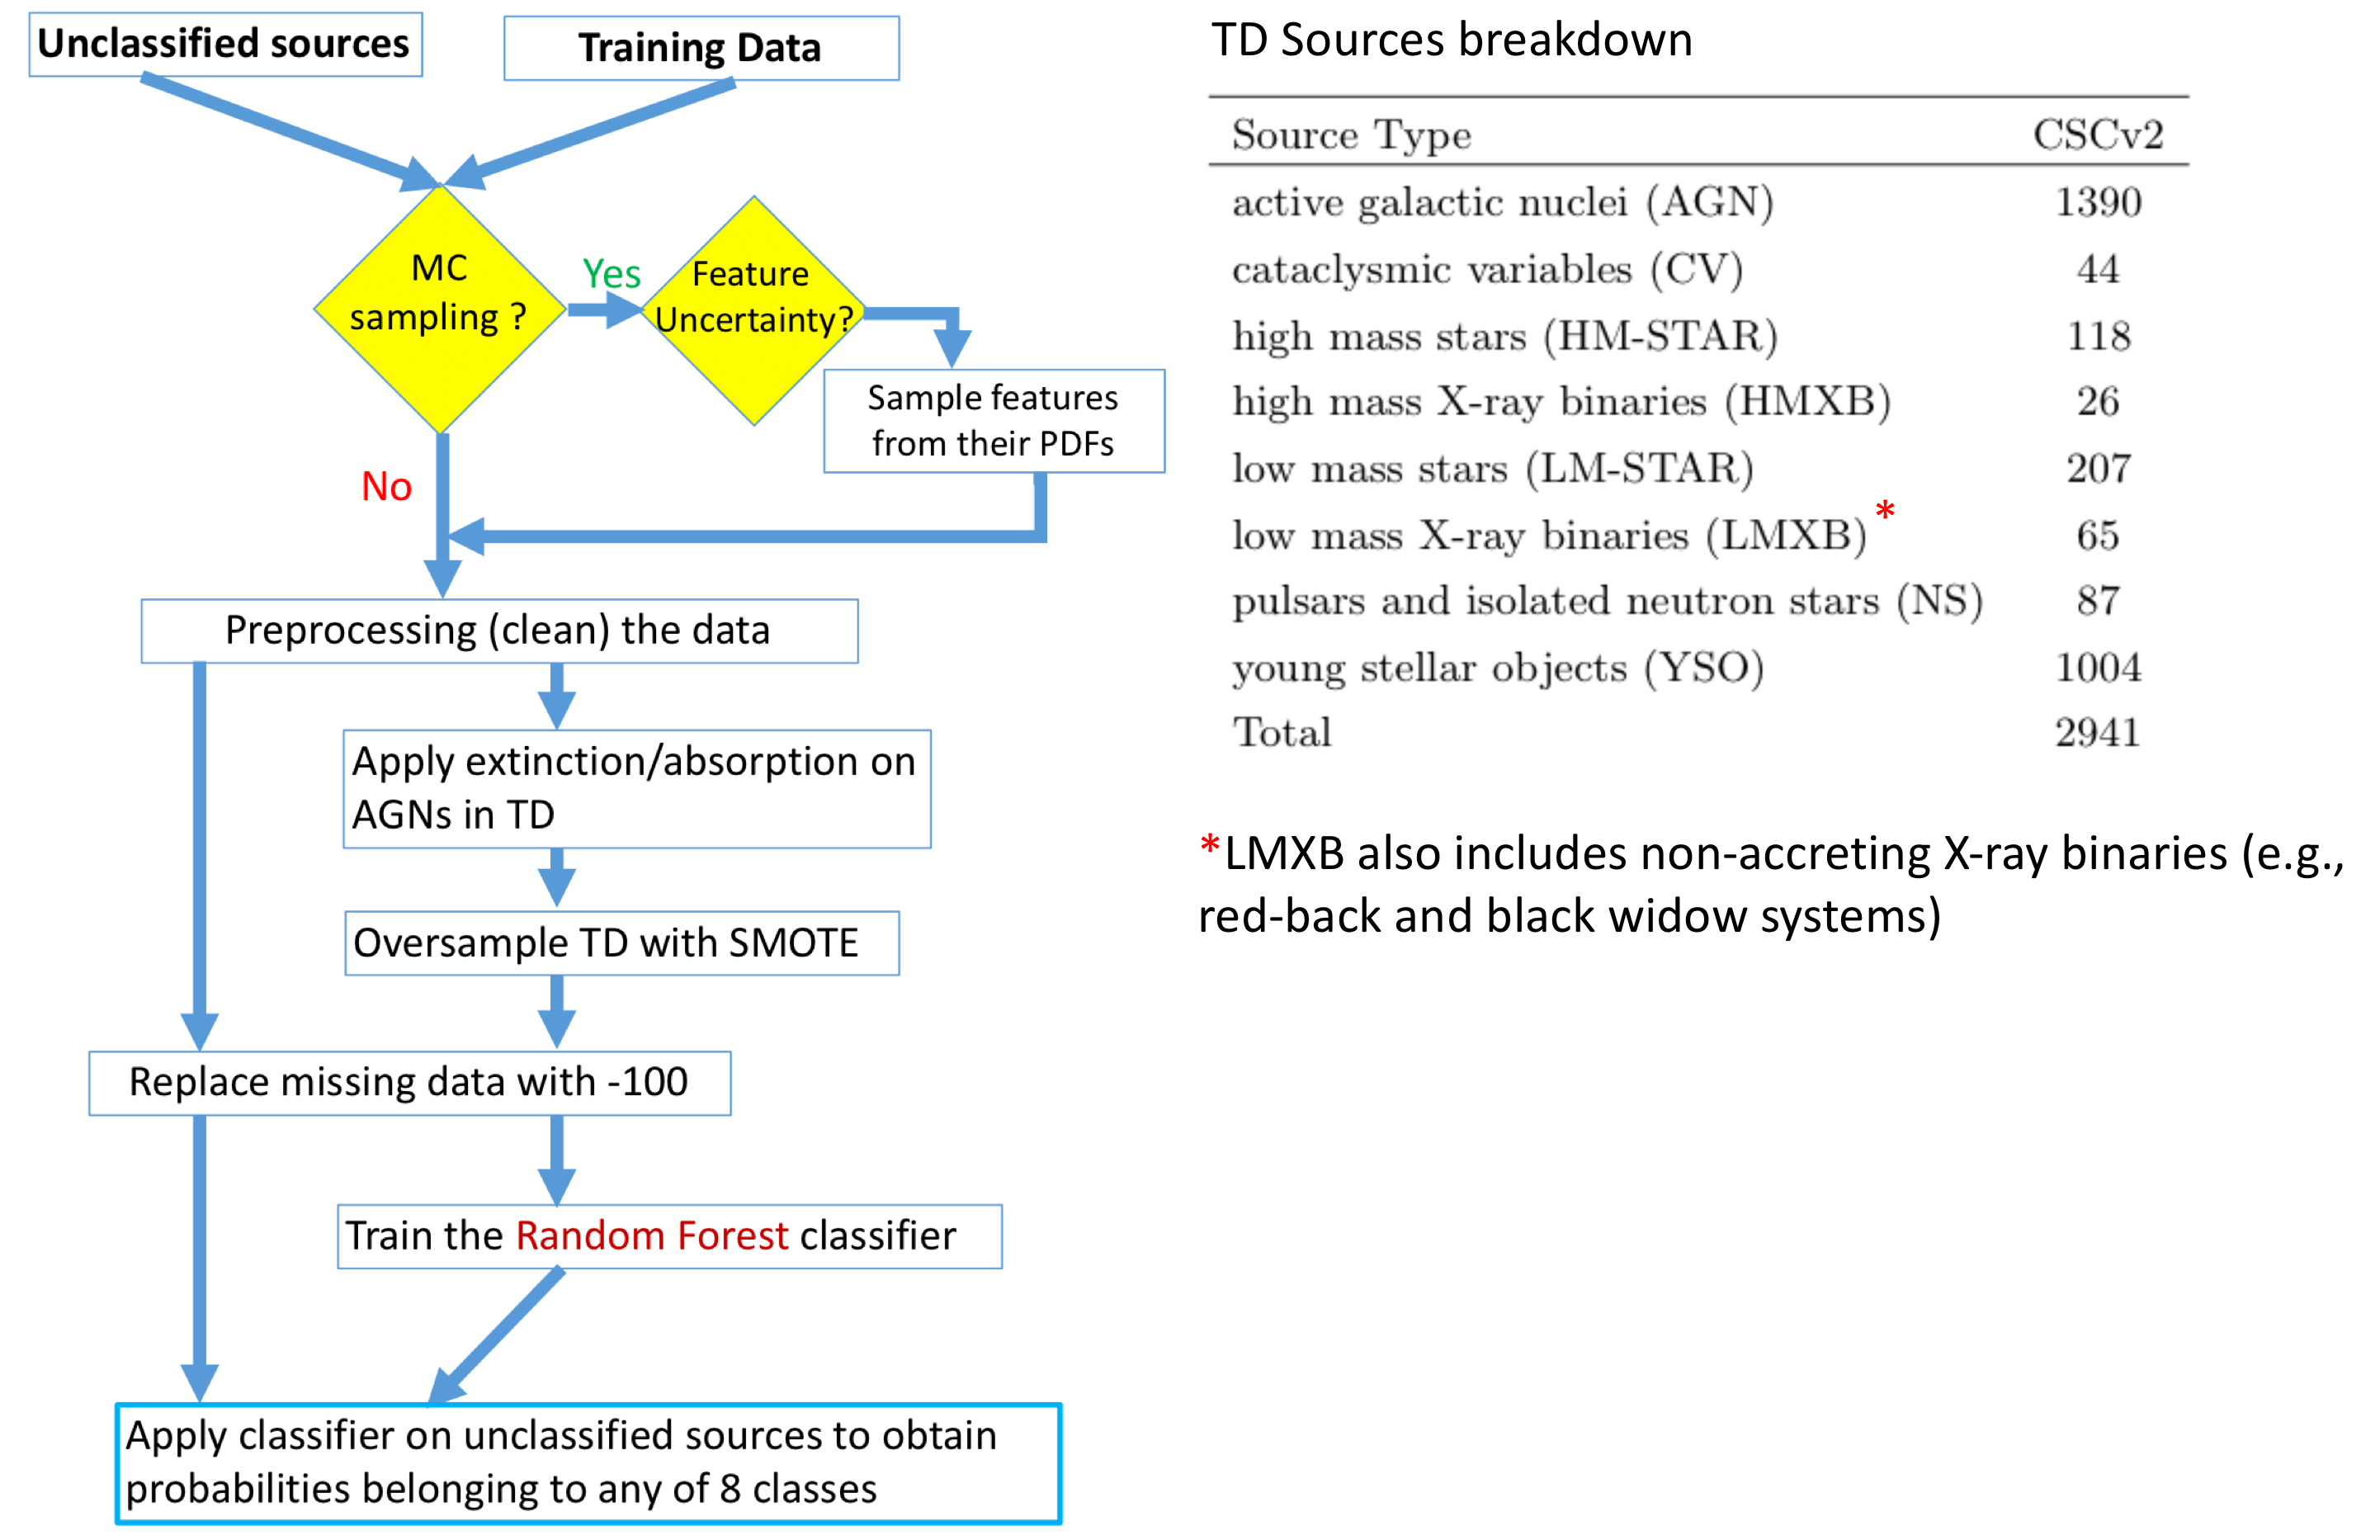

In [5]:
display(Image(filename='../../files/figs/flowchart_TD_breakdown.png',width = 600))

#### Define a circular region of interest with detections available from CSCv2 (ACIS chips only)

* field_name
* RA, DEC, radius: RA (right ascension) and Dec (declination) coordinates and radius (in arcmin) of the field

In [6]:



field_name = 'NGC3532'

RA = 166.28875

DEC = -58.85

radius = 12 # in arcmin 



# Some other examples of regions of interest 

#field_name = 'Trumpler18'
#RA, DEC,radius = 167.9712649, -60.6184559, 12


# creating the directories for saving the data and results 

data_dir = f'./data/{field_name}' # data directory to save the file

dir_out = f'./{field_name}_results' # classification results directory
dir_plot = dir_out+'/plot' # plots directory
Path(dir_out).mkdir(parents=True, exist_ok=True)
Path(dir_plot).mkdir(parents=True, exist_ok=True)


#### Cone search -- new version using CSCview_conesearch function

* search_engine: The database can be accessed using either curl or wget tool. You may run into some bugs when downloading data using curl, then wget is suggested to use. 
* csc_version: curl can access to different Chandra Source Catalog version, including 2.0 and current version (which includes more data and keeps updating on a daily basis). wget can only access to 2.0 version so the csc_version parameter does not apply to wget 


In [7]:

search_engine = 'wget'#'curl'

# installing wget is required to run with the 'wget' option

csc_version = '2.0' #'current' # '2.0'

df_res = CSCview_conesearch(field_name, RA, DEC, radius,'./data/query',engine='wget',csc_version='current')

#df_res['ra'] = Angle(df_res['ra'], 'hourangle').degree
#df_res['dec'] = Angle(df_res['dec'], 'deg').degree
df_res['usrid'] = np.nan
for i, name in enumerate(df_res['name'].unique()):
    df_res.loc[df_res['name']==name, 'usrid'] = i+1
    

# you can filter on the properties of X-ray sources, i.e., X-ray significance if you uncomment the following line

# df_res = df_res[df_res.significance>=3.].reset_index()

--2022-09-16 08:22:20--  http://cda.cfa.harvard.edu/csccli/getProperties?query=SELECT%20DISTINCT%20dbo.separation(m.ra,m.dec,166.28875,-58.85)%20as%20separation,m.name,m.ra,m.dec,m.err_ellipse_r0,m.err_ellipse_r1,m.err_ellipse_ang,m.significance,m.likelihood_class,m.conf_flag,m.dither_warning_flag,m.extent_flag,m.pileup_flag,m.sat_src_flag,m.streak_src_flag,m.var_flag,m.var_inter_hard_flag,m.flux_aper90_b,m.flux_aper90_lolim_b,m.flux_aper90_hilim_b,m.flux_aper90_h,m.flux_aper90_lolim_h,m.flux_aper90_hilim_h,m.flux_aper90_m,m.flux_aper90_lolim_m,m.flux_aper90_hilim_m,m.flux_aper90_s,m.flux_aper90_lolim_s,m.flux_aper90_hilim_s,m.var_intra_index_b,m.var_intra_prob_b,m.ks_intra_prob_b,m.kp_intra_prob_b,m.var_inter_index_b,m.var_inter_prob_b,m.var_inter_sigma_b,m.nh_gal,m.flux_powlaw,m.flux_powlaw_lolim,m.flux_powlaw_hilim,m.powlaw_gamma,m.powlaw_gamma_lolim,m.powlaw_gamma_hilim,m.powlaw_gamma_rhat,m.powlaw_nh,m.powlaw_nh_lolim,m.powlaw_nh_hilim,m.powlaw_nh_rhat,m.powlaw_ampl,m.powlaw_ampl_

In [8]:
df_res

separation                    name            ra           dec  \
0         15.39   2CXO J110507.4-585105   11 05 07.45  -58 51 05.47   
1         26.29   2CXO J110507.1-585120   11 05 07.16  -58 51 20.39   
2         31.68   2CXO J110510.3-585029   11 05 10.38  -58 50 29.44   
3         36.08   2CXO J110505.5-585038   11 05 05.59  -58 50 38.30   
4         57.76   2CXO J110502.0-585111   11 05 02.02  -58 51 11.93   
5         58.91   2CXO J110503.0-585133   11 05 03.09  -58 51 33.95   
6         67.35   2CXO J110517.7-585044   11 05 17.74  -58 50 44.43   
7         67.89   2CXO J110507.7-585206   11 05 07.74  -58 52 06.81   
8         72.39   2CXO J110509.4-584947   11 05 09.47  -58 49 47.62   
9         74.77   2CXO J110514.1-585204   11 05 14.12  -58 52 04.75   
10        85.56   2CXO J110458.3-585053   11 04 58.31  -58 50 53.18   
11        87.90   2CXO J110514.3-584941   11 05 14.39  -58 49 41.50   
12        93.12   2CXO J110459.0-585012   11 04 59.00  -58 50 12.20   
13        95.08   2CXO J110500.9-584950   11 05 00.93  -58 49 50.57   
14        96.16   2CXO J110506.8-584925   11 05 06.88  -58 49 25.69   
15       100.53   2CXO J110458.6-585156   11 04 58.61  -58 51 56.86   
16       101.77   2CXO J110500.7-584942   11 05 00.74  -58 49 42.94   
17       104.28   2CXO J110457.1-585014   11 04 57.18  -58 50 14.91   
18       109.90   2CXO J110520.2-584950   11 05 20.22  -58 49 50.08   
19       110.08   2CXO J110456.3-585015   11 04 56.35  -58 50 15.11   
20       112.54   2CXO J110458.7-584942   11 04 58.75  -58 49 42.78   
21       114.52   2CXO J110519.6-585221   11 05 19.67  -58 52 21.47   
22       116.36   2CXO J110454.3-585053   11 04 54.33  -58 50 53.36   
23       116.79   2CXO J110518.8-585230   11 05 18.87  -58 52 30.19   
24       121.43   2CXO J110510.2-584858   11 05 10.25  -58 48 58.79   
25       123.15   2CXO J110500.5-585242   11 05 00.57  -58 52 42.84   
26       123.20   2CXO J110520.8-585224   11 05 20.82  -58 52 24.80   
27       123.26   2CXO J110525.1-585102   11 05 25.18  -58 51 02.66   
28       123.51   2CXO J110505.8-585300   11 05 05.89  -58 53 00.64   
29       124.13   2CXO J110457.8-584933   11 04 57.89  -58 49 33.01   
30       124.72   2CXO J110525.1-585041   11 05 25.20  -58 50 41.62   
31       126.06   2CXO J110516.3-584906   11 05 16.38  -58 49 06.54   
32       128.93   2CXO J110458.1-585235   11 04 58.17  -58 52 35.76   
33       130.95   2CXO J110458.5-585241   11 04 58.58  -58 52 41.17   
34       132.66   2CXO J110523.7-584949   11 05 23.76  -58 49 49.21   
35       134.67   2CXO J110526.3-585124   11 05 26.36  -58 51 24.85   
36       135.32   2CXO J110453.1-585008   11 04 53.18  -58 50 08.44   
37       137.58   2CXO J110527.0-585103   11 05 27.03  -58 51 03.36   
38       137.60   2CXO J110523.8-585218   11 05 23.86  -58 52 18.59   
39       139.75   2CXO J110456.2-584923   11 04 56.23  -58 49 23.92   
40       143.24   2CXO J110451.8-585147   11 04 51.88  -58 51 47.54   
41       146.14   2CXO J110450.7-585034   11 04 50.77  -58 50 34.09   
42       146.64   2CXO J110515.5-584841   11 05 15.53  -58 48 41.56   
43       149.55   2CXO J110502.7-585320   11 05 02.71  -58 53 20.55   
44       151.10   2CXO J110458.2-584855   11 04 58.21  -58 48 55.80   
45       153.82   2CXO J110518.3-584842   11 05 18.30  -58 48 42.98   
46       154.32   2CXO J110454.3-584918   11 04 54.33  -58 49 18.42   
47       154.95   2CXO J110515.1-584831   11 05 15.17  -58 48 31.89   
48       158.30   2CXO J110449.7-585144   11 04 49.73  -58 51 44.80   
49       158.58   2CXO J110524.4-584913   11 05 24.47  -58 49 13.76   
50       164.29   2CXO J110512.4-585342   11 05 12.48  -58 53 42.42   
51       171.62   2CXO J110453.3-584900   11 04 53.38  -58 49 00.91   
52       174.38   2CXO J110528.5-584930   11 05 28.59  -58 49 30.65   
53       177.05   2CXO J110451.0-584913   11 04 51.04  -58 49 13.87   
54       179.81   2CXO J110446.1-585110   11 04 46.16  -58 51 10.29   
55       181.09   2CXO J11053

#### Cone search -- old version since it can not access to CSC Current Database

* query with the PyVo package 
* only significant X-ray sources (significance>=3) are selected for classification, which can be changed to your own purposes

In [9]:
'''
cone = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch')
field = SkyCoord(RA, DEC, unit="deg") 
maxrad = radius * u.arcmin
results = cone.search(pos=field, radius=maxrad, verbosity=2)
df_res = results.to_table().to_pandas()
df_sig = df_res[df_res.significance>=3.].reset_index()
print(len(df_sig),'sources left with S/N >=3 from',len(df_res), 'sources')
'''

'\ncone = vo.dal.SCSService(\'http://cda.cfa.harvard.edu/csc2scs/coneSearch\')\nfield = SkyCoord(RA, DEC, unit="deg") \nmaxrad = radius * u.arcmin\nresults = cone.search(pos=field, radius=maxrad, verbosity=2)\ndf_res = results.to_table().to_pandas()\ndf_sig = df_res[df_res.significance>=3.].reset_index()\nprint(len(df_sig),\'sources left with S/N >=3 from\',len(df_res), \'sources\')\n'

* prepare_field function extracts per-observation CSC data, calculates average X-ray fluxes and hardness ratio, X-ray variability from multiple X-ray detections, and applies cross-matching with multiwavelength catalogs (GAIA, 2MASS, WISE)


In [10]:

df_MW = prepare_field(df_res, data_dir, './data/query', field_name, name_col='name',search_mode='cone_search',engine=search_engine,csc_version=csc_version,create_perobs=False,convert_hms_to_deg=False)


There are 389 per-obs data.
Run nan_flux......
I/350/gaiaedr3
cross-matching to gaia
cross-matching to gaiadist
II/246/out
cross-matching to 2mass
II/365/catwise
cross-matching to catwise
II/363/unwise
cross-matching to unwise
II/328/allwise
cross-matching to allwise
307 counterparts matched for gaia
241 counterparts matched for 2mass
173 counterparts matched for catwise
195 counterparts matched for unwise
116 counterparts matched for allwise


#### read training data , field data and absroption file that is needed to calculate absorption correction 

In [11]:
TD = pd.read_csv('../../files/CSC_TD_MW_remove.csv')
TD['Class'] = TD['Class'].replace({'NS_BIN':'LMXB'})
TD = prepare_cols(TD, cp_thres=0, TD=True, NS_MWdrop=False, STAR_classremove=['HM-STAR','LM-STAR','YSO']) # some filtering 

field = pd.read_csv(f'{data_dir}/{field_name}_MW_remove.csv')
print(len(field[field.name.isin(TD.name)]), 'field sources are in the TD:')
print(TD.loc[TD.name.isin(field.name), ['name','Class']])
TD.loc[TD.name.isin(field.name), :].to_csv(f'{data_dir}/TD_{field_name}_MW_remove.csv',index=False)
field = field[~field.name.isin(TD.name)].reset_index(drop=True)
field.to_csv(f'{data_dir}/{field_name}_MW_remove.csv',index=False)

field = prepare_cols(field, cp_thres=0, vphas=False,gaiadata=False) # apply with some filterings

# tbabs from xpsec Wilms, Allen & McCray (2000)
tbabs_ene, tbabs_cross = np.loadtxt('../../files/tbabs.data', skiprows=0)
tbabs_cross *= 100


Remove 21 [('LM-STAR', 1), ('YSO', 20)]
Final breakdown 2941 [('AGN', 1390), ('CV', 44), ('HM-STAR', 118), ('HMXB', 26), ('LM-STAR', 207), ('LMXB', 65), ('NS', 87), ('YSO', 1004)]
2 field sources are in the TD:
                       name    Class
1789  2CXO J110435.9-584520  LM-STAR
1790  2CXO J110457.9-584742  LM-STAR


#### MUWCLASS pipeline settings

In [12]:
Xcat = 'CSC' # CSCv2 catalog is used 
Uncer_flag = True # applying Monte-Carlo samplings to account the measurement uncertainties 
num_sample = 100 # number of MC samplings, we use 1000 for our classification results in https://arxiv.org/abs/2206.13656, 100 is runnable with a few minutes on a laptop
class_labels = ['AGN','CV','HM-STAR','LM-STAR','HMXB','LMXB','NS','YSO'] # there are 8 classes of X-ray sources in our current pipeline 


#### Preprocessing, including Monte-Carlo sampling of feature uncertainties, applying field-specific reddening on AGNs from the TD, standardization, oversampling to mitigate imbalance in TD (see Section 3 in https://arxiv.org/abs/2206.13656)

In [13]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SMOTEN, KMeansSMOTE

oversample_algorithms = {
    'SMOTE': SMOTE( k_neighbors=4, n_jobs=-1), 
    'ADASYN':ADASYN(n_neighbors=4, n_jobs=-1), 
    'BorderlineSMOTE':BorderlineSMOTE(k_neighbors=4,n_jobs=-1), 
    #'KMeansSMOTE':KMeansSMOTE(cluster_balance_threshold=0.01,k_neighbors=4, n_jobs=-1) 
}

oversample_algo = 'SMOTE' # you can add other oversampling algorithms into the list above and change the algorithm that you want to use here

In [14]:
# this step takes a few minutes, and it increases linearly as you increase the num_sample (number of MC samplings)

num_cores = mp.cpu_count()
pool = mp.Pool(int(num_cores))

%time arr = [pool.apply(class_prepare_oversample, args=(TD, field, True, RA, DEC, Xcat, 'nodist', Uncer_flag, i, i, tbabs_ene, tbabs_cross,oversample_algorithms[oversample_algo])) for i in range(num_sample)]


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


CPU times: user 436 ms, sys: 230 ms, total: 666 ms
Wall time: 37 s


#### Our pipeline uses Random Forest (RF) algorithm as the default model. 
#### In this demo, we offer the flexibilities that users can choose their preferred model available from scikit-learn package. 

https://scikit-learn.org/stable/supervised_learning.html


In [15]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier

model_dict = {
    'RF': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
    'SVC':SVC(gamma='auto',probability=True), 
    'KNeighbor': KNeighborsClassifier(n_neighbors=10),
    'bagging': BaggingClassifier(), 
    'extratrees': ExtraTreesClassifier(n_estimators=300), 
    'GB': GradientBoostingClassifier()
}

model = 'RF' # you can add models into the model list above and change the model that you want to use here

#### running the classification (training, applying model to field data and saving classification results )

In [16]:
%%time
# this step takes a few minutes

arr2 = list(zip(arr, [model_dict[model]]*len(arr)))

if __name__ == '__main__':
    
    with mp.Pool() as pool:
        res = pool.map(class_train_model_and_classify, arr2) 
#print(res)
class_save_res(res, dir_out)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


CPU times: user 443 ms, sys: 411 ms, total: 854 ms
Wall time: 20.2 s


#### combining the classification results (MC samplings provide the ability to calculate uncertainties on classification probability) 

In [17]:
TD_evaluation = pd.read_csv('../../files/LOO_classes.csv')
field_mw_class = combine_class_result(field_name, data_dir, dir_out, class_labels, TD_evaluation,radius)#,weight_CM=True)

field_XCLASS = field_mw_class.rename(columns={'significance':'Signif.'})




#### select confident classified sources based on Confidence Threshold parameter (see Eq. (7) in https://arxiv.org/abs/2206.13656) for visualization 

In [18]:
CT_cut = 2 # which can be changed

#### combining the classification results (MC samplings provide the ability to calculate uncertainties on classification probability) & saving the file for XCLASS plotting

In [19]:
field_XCLASS.loc[field_XCLASS.CT>=CT_cut,['name','ra','dec','Class','F_b','F_h','F_m','F_s','P_inter','P_intra','Signif.','G','BP','RP','J','H','K','W1','W2','W3']].to_csv(f'{dir_out}/{field_name}_XCLASS.csv')


## Visualization of classification results 

### MUWCLASS pipeline performance evaluation 

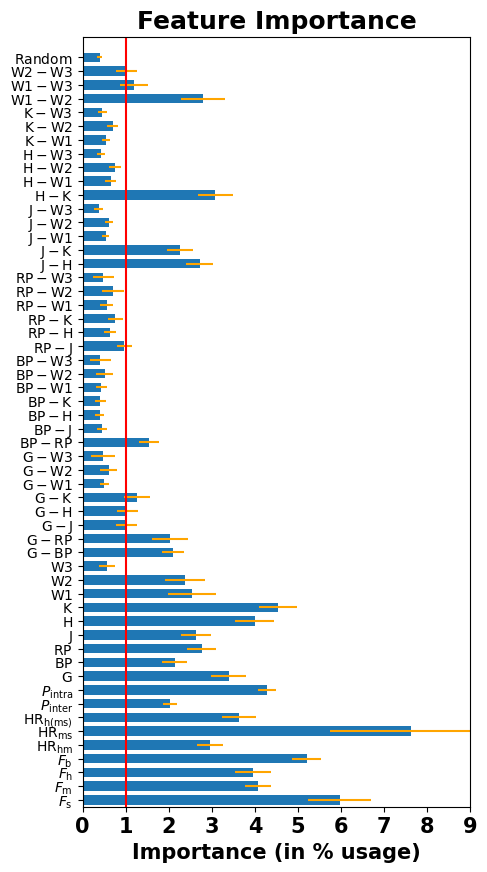

In [20]:
# confusion matrix
recall_cm = plot_confusion_matrix(pd.read_csv('../../files/LOO_classes.csv'),classes=class_labels,title='Norm. Confusion Matrix (%)',width=450,height=400)
show(recall_cm)

# feature importance
feaimps = pd.read_csv('../../files/feature_importance.csv')
fea_imp = plot_Feature_Importance_withSTD(feaimps.iloc[0], feaimps.iloc[1],feaimps.columns,400,800)


### XCLASS interactive plotting website of TD overplotted with field data 

https://home.gwu.edu/~kargaltsev/XCLASS/

* click on Choose File and upload {dir_out}/{field_name}_XCLASS.csv to overplot the field data


#### Visualizing the classification matrix
The classification matrix shows the probability array (the probability to be classified to 8 classes of X-ray emitters from TD) in each row for each source in the field 

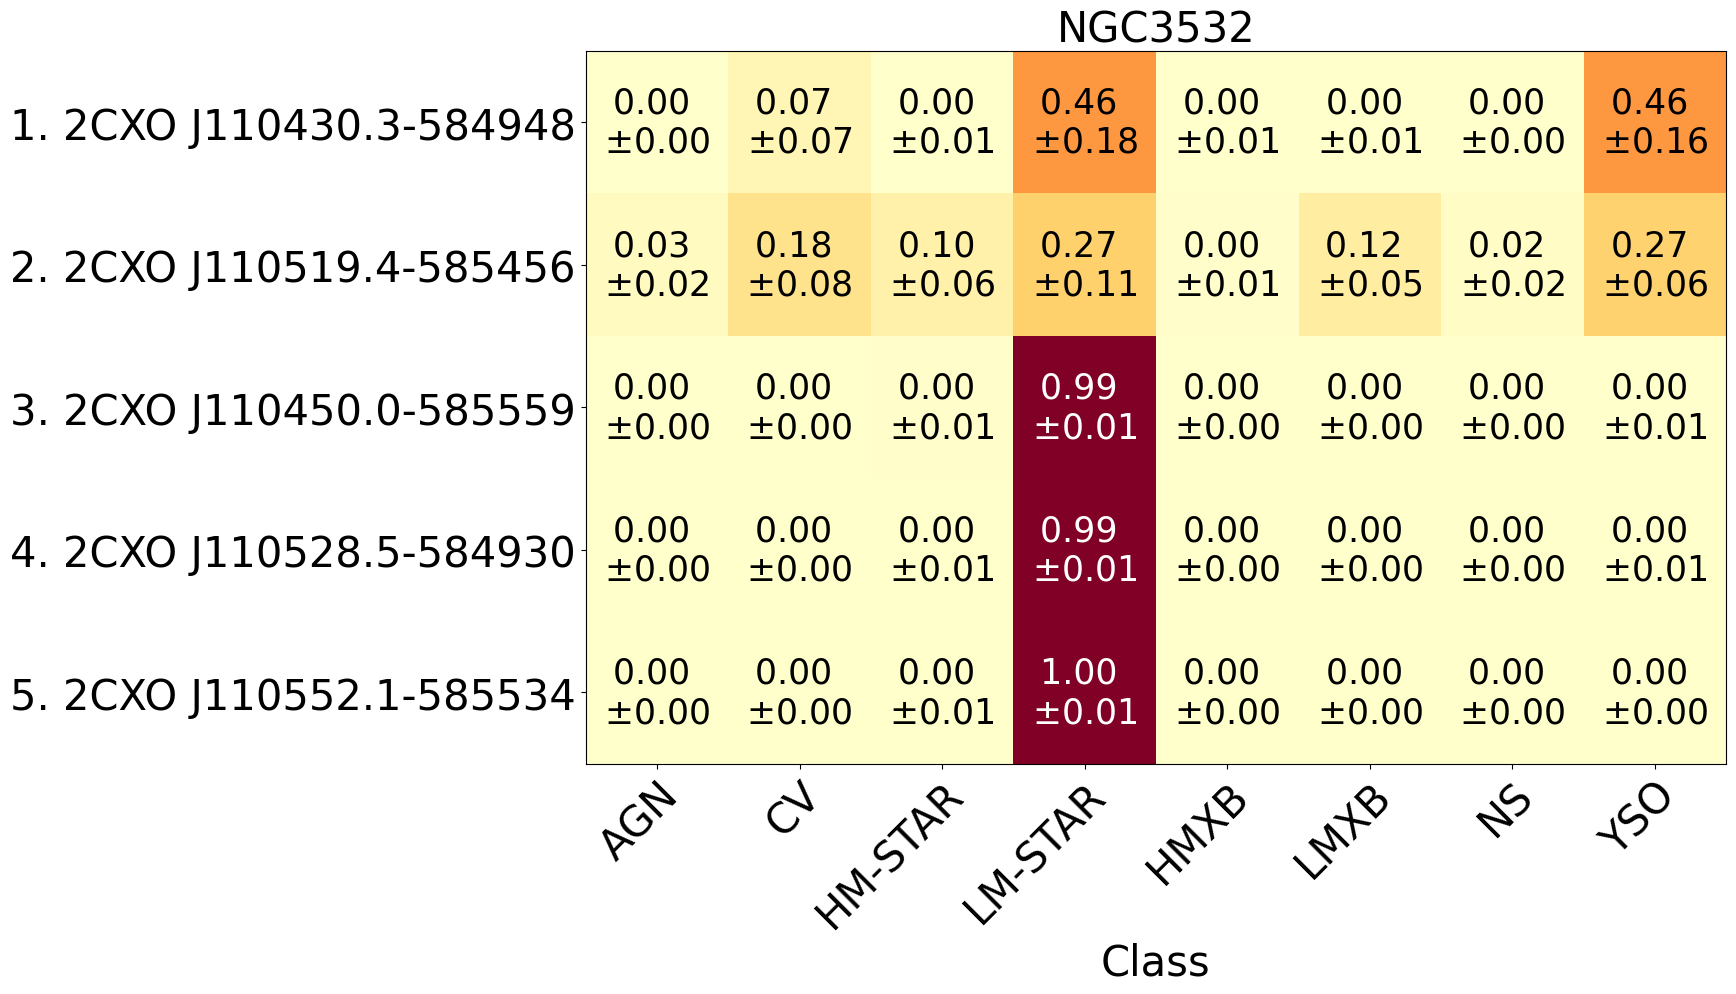

In [21]:
# the sources to plot the classification matrix can be defined by users

# this example plots the top 2 least confidently classified sources and top 3 most confidently classified sources
df_class_matrix = field_mw_class[field_mw_class.CT>0].sort_values(by=['CT'])
df_class_matrix = pd.concat([df_class_matrix.head(2), df_class_matrix.tail(3)])

plot_class_matrix(field_name, df_class_matrix, dir_plot, class_labels)

#### The histograms of all and confident classifications 

<AxesSubplot: title={'center': 'Confident Classification'}>

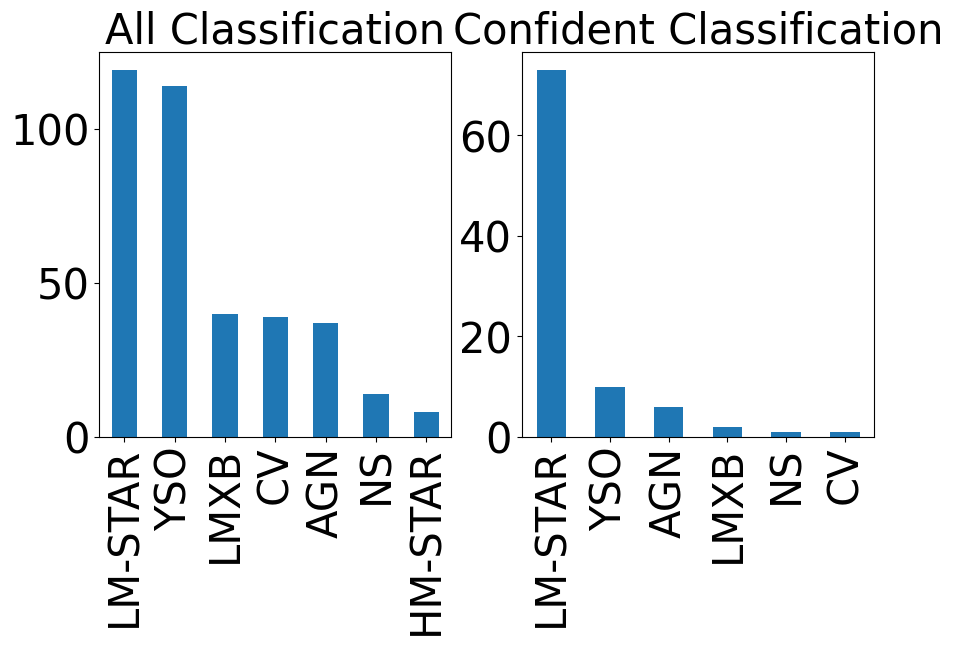

In [22]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
field_mw_class['Class'].value_counts().plot(kind='bar', ax=ax1, title='All Classification')
field_mw_class[field_mw_class.CT>=CT_cut]['Class'].value_counts().plot(kind='bar', ax=ax2,title='Confident Classification')


#### multi-band spectrum of TD overplotted with field data (in cyan)
* set plot_classes the classes of sources that you want to plot the broadband SEDs
* The fluxes are normalized so that the medium band fluxes are all the same
* The color indicates the density of the sources from the TD In the multi-band spectrum

In [23]:
TD.columns

Index(['name', 'ra', 'dec', 'PU', 'significance', 'Fcsc_s', 'e_Fcsc_s',
       'Fcsc_m', 'e_Fcsc_m', 'Fcsc_h', 'e_Fcsc_h', 'flux_aper90_ave_b',
       'e_flux_aper90_ave_b', 'var_intra_prob', 'var_inter_prob', 'CSC_flags',
       'EDR3Name_gaia', 'RA_pmcor_gaia', 'DEC_pmcor_gaia', 'Gmag', 'e_Gmag',
       'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'Plx', 'e_Plx', 'PM', 'rgeo',
       'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo', 'B_rpgeo', 'cp_flag_gaia',
       '_2MASS_2mass', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag',
       'cp_flag_2mass', 'Name_catwise', 'W1mag_catwise', 'e_W1mag_catwise',
       'W2mag_catwise', 'e_W2mag_catwise', 'cp_flag_catwise', 'objID_unwise',
       'W1mag_unwise', 'e_W1mag_unwise', 'W2mag_unwise', 'e_W2mag_unwise',
       'cp_flag_unwise', 'AllWISE_allwise', 'W1mag_allwise', 'e_W1mag_allwise',
       'W2mag_allwise', 'e_W2mag_allwise', 'W3mag', 'e_W3mag', 'W4mag',
       'e_W4mag', 'cp_flag_allwise', 'Class', 'cp_flag_wise12', 'which_wise12',
       'W1m

In [24]:
TD_mw = TD.rename(columns={'Fcsc_s':'F_s','Fcsc_m':'F_m','Fcsc_h':'F_h','flux_aper90_ave_b':'F_b',\
                            'Gmag':'G','BPmag':'BP','RPmag':'RP','Jmag':'J','Hmag':'H','Kmag':'K','W1mag':'W1','W2mag':'W2','W3mag':'W3',\
                            'var_intra_prob':'P_intra', 'var_inter_prob':'P_inter'})

In [26]:
plot_classes = ['YSO','LMXB','LM-STAR','NS','CV','AGN']
plotlist = [plot_bbsed(TD_mw, field_mw_class, dir_plot, plot_class=c, save_class=[], confidence=True, TD_name_col=False) for c in plot_classes]

layout = hv.Layout(plotlist).cols(3)

layout

:Layout
   .Overlay.I   :Overlay
      .Scatter.I  :Scatter   [Frequency]   (Flux Norm,Source Density, Flux Norm,Flux,Band)
      .Scatter.II :Scatter   [Frequency]   (Flux Norm,name,Flux,Band)
   .Overlay.II  :Overlay
      .Scatter.I  :Scatter   [Frequency]   (Flux Norm,Source Density, Flux Norm,Flux,Band)
      .Scatter.II :Scatter   [Frequency]   (Flux Norm,name,Flux,Band)
   .Overlay.III :Overlay
      .Scatter.I  :Scatter   [Frequency]   (Flux Norm,Source Density, Flux Norm,Flux,Band)
      .Scatter.II :Scatter   [Frequency]   (Flux Norm,name,Flux,Band)
   .Overlay.IV  :Overlay
      .Scatter.I  :Scatter   [Frequency]   (Flux Norm,Source Density, Flux Norm,Flux,Band)
      .Scatter.II :Scatter   [Frequency]   (Flux Norm,name,Flux,Band)
   .Overlay.V   :Overlay
      .Scatter.I  :Scatter   [Frequency]   (Flux Norm,Source Density, Flux Norm,Flux,Band)
      .Scatter.II :Scatter   [Frequency]   (Flux Norm,name,Flux,Band)
   .Overlay.VI  :Overlay
      .Scatter.I  :Scatter   [Frequency]   (Flux Norm,Source Density, Flux Norm,Flux,Band)
      .Scatter.II :Scatter   [Frequency]   (Flux Norm,name,Flux,Band)

#### plotting multi-band field images with ipyaladin 

In [28]:

aladin = ipyal.Aladin(target=str(RA)+' '+str(DEC), fov=radius/20)


dtb = QTable.from_pandas(field_mw_class[field_mw_class.conf_flag>0])

aladin

Aladin(fov=0.6, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'ov…

In [53]:
aladin.add_table(dtb)

## Q&A
* What kind of user interface would you like for the MUWCLASS pipeline? 
* Do you have any comments or suggestions that can help us improve the MUWCLASS pipeline?